# What is happening in the Birmingham property market?

In [1]:
# Import needed packages
import pandas as pd
import getpass
import shapefile
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as dates
import datetime as dt
import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame as gdf
import geoplot as gplt
import geoplot.crs as gcrs
from pyproj import Proj, transform
import mapclassify as mc
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import log
from sklearn import preprocessing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
# Declare functions
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
# Read the data
dfLRP = pd.read_csv('../Land Registry Price Paid Data.csv', sep=',',low_memory=False)
dfPTY = pd.read_csv('../VOA Property Type Data.csv', sep=',',low_memory=False)
dfPAY = pd.read_csv('../VOA Property Age Data.csv', sep=',',low_memory=False)


In [4]:
# keep only the ones that are within +1 to -1 standard deviations in the column 'SalePrice'.
dfLRP2 = dfLRP[np.abs(dfLRP.SalePrice-dfLRP.SalePrice.mean()) <= (1*dfLRP.SalePrice.std())]
dfLRP2 = dfLRP2[~(np.abs(dfLRP2.SalePrice-dfLRP2.SalePrice.mean()) > (1*dfLRP2.SalePrice.std()))]
dates = dfLRP2['SaleDate'].values
dfLRP2.SaleDate = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

In [5]:
# Select only dates in specific year
dfLRP2009 = dfLRP2.loc[dfLRP2['SaleDate'].map(lambda x: x.year) == 2009]
dfLRP2011 = dfLRP2.loc[dfLRP2['SaleDate'].map(lambda x: x.year) == 2011]
dfLRP2013 = dfLRP2.loc[dfLRP2['SaleDate'].map(lambda x: x.year) == 2013]
dfLRP2015 = dfLRP2.loc[dfLRP2['SaleDate'].map(lambda x: x.year) == 2015]
dfLRP2017 = dfLRP2.loc[dfLRP2['SaleDate'].map(lambda x: x.year) == 2017]
dfLRP2019 = dfLRP2.loc[dfLRP2['SaleDate'].map(lambda x: x.year) == 2019]
dfLRP0913 = dfLRP2.loc[dfLRP2['SaleDate'].map(lambda x: x.year) <= 2013]
dfLRP1319 = dfLRP2.loc[dfLRP2['SaleDate'].map(lambda x: x.year) > 2013]


In [6]:
# Read the shape files for Birmingham
dfGEO = geopandas.read_file("../HS2.shp")
dfBirmN = geopandas.read_file("../E08000025/NamedPlace.shp")
dfBirm = geopandas.read_file("../E08000025_2/E08000025_Birmingham.shp")

#Convert UTM to LATLON
dfBirmLatLon = dfBirm.to_crs(epsg=4326)
dfGEOLatLon = dfGEO.to_crs(epsg=4326)

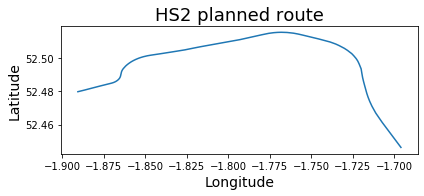

In [7]:
#Route of HS2 in Birmingham
dfGEOLatLon.plot()
plt.title("HS2 planned route",fontsize=18)
plt.xlabel("Longitude",fontsize=14)
plt.ylabel("Latitude",fontsize=14)
plt.tight_layout()
plt.show()


## What has happened to Birmingham property prices?


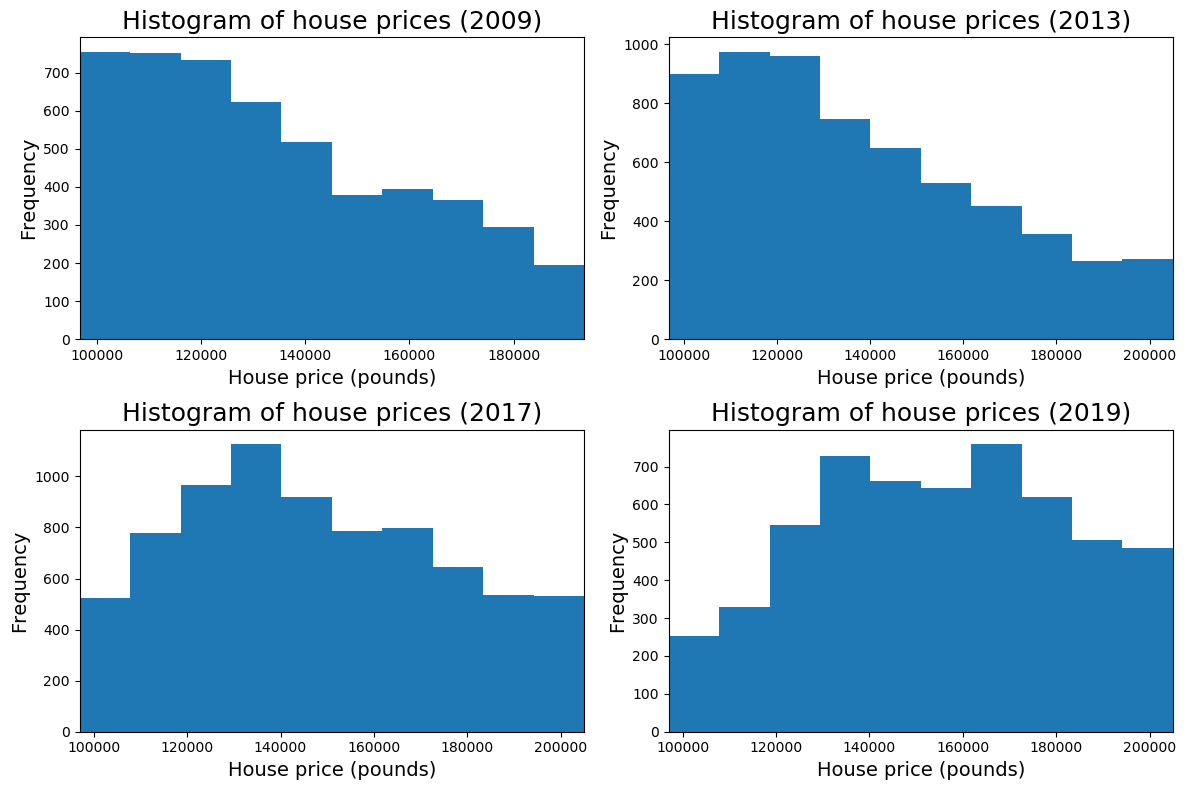

In [8]:
# Histogram of house prices in Birmingham
dfPD = dfLRP2009[['SalePrice','SaleDate']]
pricehist = dfPD.SalePrice.values


#Remove house prices more or less than 2std
pricehist = reject_outliers(pricehist)
plt.figure(figsize=(12,8), dpi=100)
plt.subplot(221)
plt.hist(pricehist)
plt.title("Histogram of house prices (2009)",fontsize=18)
plt.xlabel("House price (pounds)",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xlim(xmin=pricehist.min(), xmax = pricehist.max())

dfPD = dfLRP2013[['SalePrice','SaleDate']]
pricehist = dfPD.SalePrice.values
plt.subplot(222)
plt.hist(pricehist)
plt.title("Histogram of house prices (2013)",fontsize=18)
plt.xlabel("House price (pounds)",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xlim(xmin=pricehist.min(), xmax = pricehist.max())

dfPD = dfLRP2017[['SalePrice','SaleDate']]
pricehist = dfPD.SalePrice.values
plt.subplot(223)
plt.hist(pricehist)
plt.title("Histogram of house prices (2017)",fontsize=18)
plt.xlabel("House price (pounds)",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xlim(xmin=pricehist.min(), xmax = pricehist.max())

dfPD = dfLRP2019[['SalePrice','SaleDate']]
pricehist = dfPD.SalePrice.values
plt.subplot(224)
plt.hist(pricehist)
plt.title("Histogram of house prices (2019)",fontsize=18)
plt.xlabel("House price (pounds)",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xlim(xmin=pricehist.min(), xmax = pricehist.max())

plt.tight_layout()
plt.show()


In [9]:
# Plot house prices trend and moving average
dfPD = dfLRP2[['SalePrice','SaleDate']]
dfPD = dfPD.sort_values(by=['SaleDate'])

# dates = dfPD['SaleDate'].values
# x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

dfPD['SaleDate'] = pd.to_datetime(dfPD.SaleDate)

# Check if any value is null or nan
print("Null values in Dataframe",dfPD.isnull().values.any())
print("Nan values in Dataframe",dfPD.isna().values.any())

dfPD.SalePrice = dfPD.groupby([(dfPD.SaleDate.dt.year),(dfPD.SaleDate.dt.month),(dfPD.SaleDate.dt.week)])['SalePrice'].transform('mean')
cols = list(dfPD)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('SaleDate')))
# use ix to reorder
dfPD = dfPD.loc[:, cols]

dfPDR = dfPD.copy()

dfPDR.SalePrice= dfPD['SalePrice'].rolling(window=500).mean()




Null values in Dataframe False
Nan values in Dataframe False


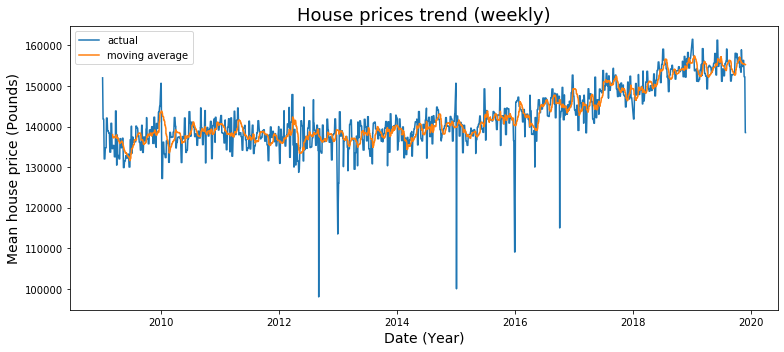

In [10]:
# Plot house prices trend and moving average
y = dfPD.SalePrice.values
x = dfPD.SaleDate.values
x_moving = dfPDR.SaleDate.values
y_moving = dfPDR.SalePrice.values

rcParams['figure.figsize'] = 11, 5

plt.plot(x,y,label="actual")
xmin, xmax, ymin, ymax = plt.axis()
plt.plot(x_moving,y_moving,label="moving average")
plt.legend(loc="upper left")
plt.title("House prices trend (weekly)",fontsize=18)
plt.xlabel("Date (Year)",fontsize=14)
plt.ylabel("Mean house price (Pounds)",fontsize=14)
plt.tight_layout()



In [11]:
# Find percentage increase of average selling price from year to year
# Percentage increase = (New number - Original number) / Original number * 100
avprice2009 = np.mean(dfLRP2009.SalePrice.values)
avprice2011 = np.mean(dfLRP2011.SalePrice.values)
avprice2013 = np.mean(dfLRP2013.SalePrice.values)
avprice2015 = np.mean(dfLRP2015.SalePrice.values)
avprice2017 = np.mean(dfLRP2017.SalePrice.values)
avprice2019 = np.mean(dfLRP2019.SalePrice.values)

perinc2011 = (avprice2011-avprice2009)/avprice2009*100
perinc2013 = (avprice2013-avprice2011)/avprice2011*100
perinc2015 = (avprice2015-avprice2013)/avprice2013*100
perinc2017 = (avprice2017-avprice2015)/avprice2015*100
perinc2019 = (avprice2019-avprice2017)/avprice2017*100

print(str(round(perinc2011,2))+"% increase from 2009 to 2011")
print(str(round(perinc2013,2))+"% increase from 2011 to 2013")
print(str(round(perinc2015,2))+"% increase from 2013 to 2015")
print(str(round(perinc2017,2))+"% increase from 2015 to 2017")
print(str(round(perinc2019,2))+"% increase from 2017 to 2019")

0.26% increase from 2009 to 2011
0.16% increase from 2011 to 2013
2.08% increase from 2013 to 2015
5.04% increase from 2015 to 2017
4.64% increase from 2017 to 2019


### Percetage changes
Maximum percentage change happened between 2015-2017. In any case, it was significantly increased compared to 2009-2013. Construction of Phase 1 of HS2 began in 2017.

### Spatial correlation of variables

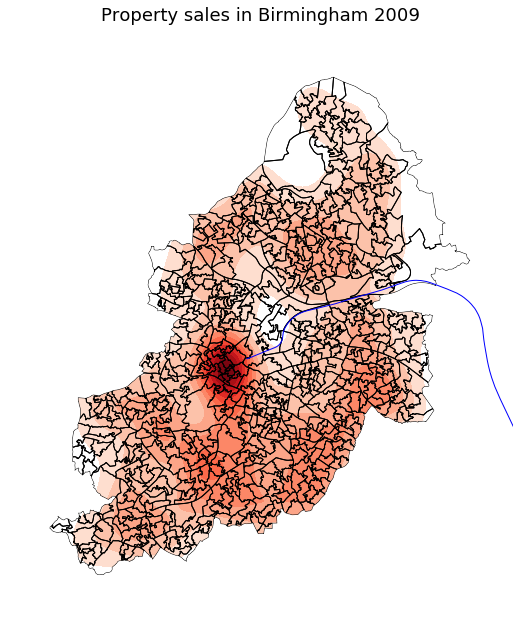

In [12]:
# Plot property transactions for 2009
dfheat = dfLRP2009[['SalePrice','Longitude','Latitude']]
dfheat['geometry']= [Point(xy) for xy in zip(dfheat.Longitude, dfheat.Latitude)]
geometry = [Point(xy) for xy in zip(dfheat.Longitude, dfheat.Latitude)]
crs = {'init': 'epsg:4326'}
gdfheat = gdf(dfheat, crs=crs, geometry=geometry)
gdfheat = gdfheat.drop(['Longitude', 'Latitude'], axis=1)
gdfheatr = gdfheat.reset_index(drop=True)



ax = gplt.kdeplot(gdfheat,clip=dfBirmLatLon.geometry,shade=True, cmap='Reds',projection=gcrs.AlbersEqualArea(),figsize=(11,11))

plt.title("Property sales in Birmingham 2009",fontsize=18)
gplt.polyplot(dfGEOLatLon, ax=ax, zorder=2,edgecolor='blue')
gplt.polyplot(dfBirmLatLon, ax=ax, zorder=1)
plt.savefig("kdeBirmingham2009.png", bbox_inches='tight', pad_inches=0.1,dpi=300)
plt.show()

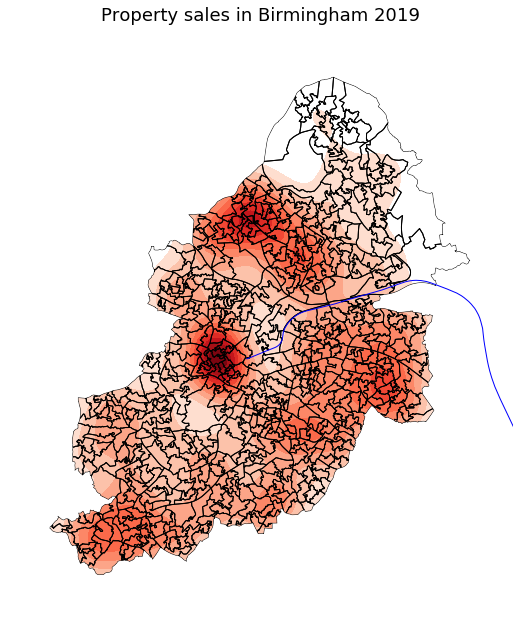

In [13]:
# Plot property transactions for 2019
dfheat = dfLRP2019[['SalePrice','Longitude','Latitude']]
dfheat['geometry']= [Point(xy) for xy in zip(dfheat.Longitude, dfheat.Latitude)]
geometry = [Point(xy) for xy in zip(dfheat.Longitude, dfheat.Latitude)]
crs = {'init': 'epsg:4326'}
gdfheat = gdf(dfheat, crs=crs, geometry=geometry)
gdfheat = gdfheat.drop(['Longitude', 'Latitude'], axis=1)
gdfheatr = gdfheat.reset_index(drop=True)



ax = gplt.kdeplot(gdfheat,clip=dfBirmLatLon.geometry,shade=True, cmap='Reds',projection=gcrs.AlbersEqualArea(),figsize=(11,11))

plt.title("Property sales in Birmingham 2019",fontsize=18)
gplt.polyplot(dfGEOLatLon, ax=ax, zorder=2,edgecolor='blue')
gplt.polyplot(dfBirmLatLon, ax=ax, zorder=1)
plt.savefig("kdeBirmingham2019.png", bbox_inches='tight', pad_inches=0.1,dpi=300)
plt.show()

### Property sales comparison between 2009 and 2019
More property transactions near the HS2 station in the second period.

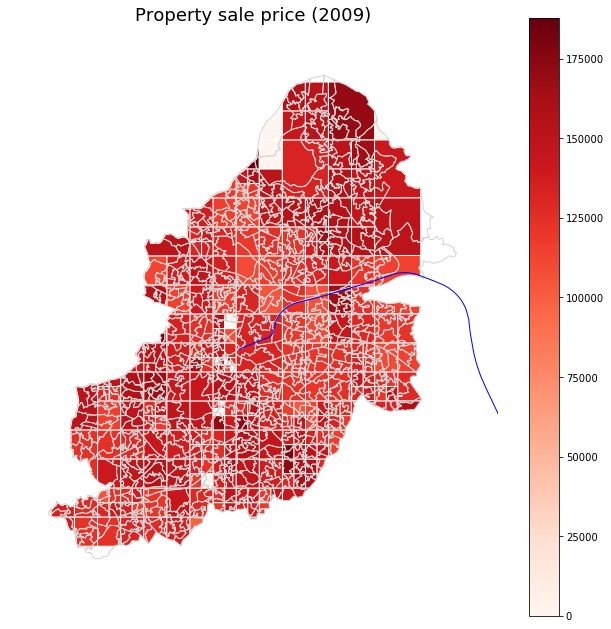

In [14]:
# Plot 2009 sale price mapped with location
dfheat = dfLRP2009[['SalePrice','Longitude','Latitude']]
dfheat['geometry']= [Point(xy) for xy in zip(dfheat.Longitude, dfheat.Latitude)]
geometry = [Point(xy) for xy in zip(dfheat.Longitude, dfheat.Latitude)]
crs = {'init': 'epsg:4326'}
gdfheat = gdf(dfheat, crs=crs, geometry=geometry)
gdfheat = gdfheat.drop(['Longitude', 'Latitude'], axis=1)
gdfheatr = gdfheat.reset_index(drop=True)

scheme = mc.NaturalBreaks(gdfheatr['SalePrice'], k=10)
ax = gplt.quadtree(
    gdfheatr, nmax=1,
    projection=gcrs.AlbersEqualArea(), clip=dfBirmLatLon,
    hue='SalePrice', cmap='Reds',
    edgecolor='white', legend=True,figsize=(11,11)
)
gplt.polyplot(dfGEOLatLon, ax=ax, zorder=2,edgecolor='blue')
gplt.polyplot(dfBirmLatLon, edgecolor='lightgrey', zorder=1, ax=ax)
plt.title("Property sale price (2009)",fontsize=18)
plt.savefig("quadBirmingham2009.png", bbox_inches='tight', pad_inches=0.1,dpi=300)
plt.show()

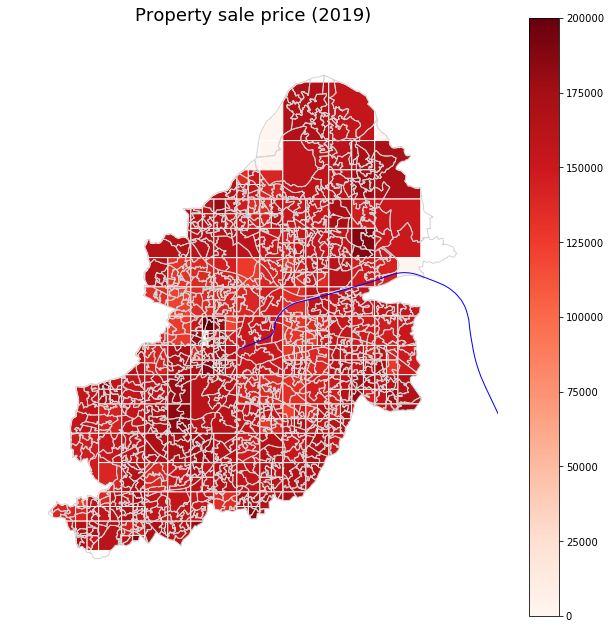

In [15]:
# Plot 2019 sale price mapped with location
dfheat = dfLRP2019[['SalePrice','Longitude','Latitude']]
dfheat['geometry']= [Point(xy) for xy in zip(dfheat.Longitude, dfheat.Latitude)]
geometry = [Point(xy) for xy in zip(dfheat.Longitude, dfheat.Latitude)]
crs = {'init': 'epsg:4326'}
gdfheat = gdf(dfheat, crs=crs, geometry=geometry)
gdfheat = gdfheat.drop(['Longitude', 'Latitude'], axis=1)
gdfheatr = gdfheat.reset_index(drop=True)

scheme = mc.NaturalBreaks(gdfheatr['SalePrice'], k=10)
ax = gplt.quadtree(
    gdfheatr, nmax=1,
    projection=gcrs.AlbersEqualArea(), clip=dfBirmLatLon,
    hue='SalePrice', cmap='Reds',
    edgecolor='white', legend=True,figsize=(11,11)
)
gplt.polyplot(dfGEOLatLon, ax=ax, zorder=2,edgecolor='blue')
gplt.polyplot(dfBirmLatLon, edgecolor='lightgrey', zorder=1, ax=ax)
plt.title("Property sale price (2019)",fontsize=18)
plt.savefig("quadBirmingham2019.png", bbox_inches='tight', pad_inches=0.1,dpi=300)
plt.show()

## What will happen to Birmingham property market?

In [16]:
# Prepare the data to perform an ARIMA model
dfARIMA = dfLRP2[['SaleDate','SalePrice']]
dfARIMA = dfARIMA.sort_values(by=['SaleDate'])
dfARIMA['SaleDate'] = pd.to_datetime(dfARIMA.SaleDate)
dfARIMA['AverageSalePrice'] = dfARIMA.groupby([(dfARIMA.SaleDate.dt.year),(dfARIMA.SaleDate.dt.month),(dfARIMA.SaleDate.dt.week)])['SalePrice'].transform('mean')
dfARIMA = dfARIMA.drop_duplicates('AverageSalePrice',keep='first')
dfARIMA = dfARIMA.drop(['SalePrice'], axis=1)
dfARIMA = dfARIMA.drop(['SaleDate'], axis=1)
dfARIMA = dfARIMA.reset_index(drop=True)
dfARIMA.head()


df = dfARIMA
df['value'] = dfARIMA['AverageSalePrice']
df = df.drop(['AverageSalePrice'], axis=1)

# Convert to thousands
df['value'] = df['value'] * 0.001

In [17]:
# Check if our timeseries is stationary, if P Value > 0.05 (Non-stationary) we go ahead with finding the order of differencing.
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.338725
p-value: 0.919838


In [54]:
#Auto ARIMA
import pmdarima as pm
model = pm.auto_arima(df.value, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # Seasonality
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=False)
print(model.summary())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=4141.971, BIC=4150.894, Fit time=0.027 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=3779.156, BIC=3792.540, Fit time=0.154 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=3779.984, BIC=3797.830, Fit time=0.529 seconds
Fit ARIMA: order=(0, 1, 3) seasonal_order=(0, 0, 0, 0); AIC=3781.644, BIC=3803.951, Fit time=0.375 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=3989.766, BIC=4003.150, Fit time=0.120 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=3780.042, BIC=3797.888, Fit time=0.240 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 0); AIC=3781.540, BIC=3803.847, Fit time=0.522 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 0, 0, 0); AIC=3783.495, BIC=3810.263, Fit time=0.568 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=3911.882, BIC=3929.728, Fit time=0.155 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_o

In [55]:
# Fit ARIMA  model
# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  640
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1886.023
Method:                       css-mle   S.D. of innovations              4.601
Date:                Wed, 29 Jan 2020   AIC                           3780.046
Time:                        19:57:43   BIC                           3797.892
Sample:                             1   HQIC                          3786.973
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0277      0.011      2.461      0.014       0.006       0.050
ar.L1.D.value     0.0449      0.043      1.056      0.291      -0.038       0.128
ma.L1.D.value    -0.9427      0.013    -

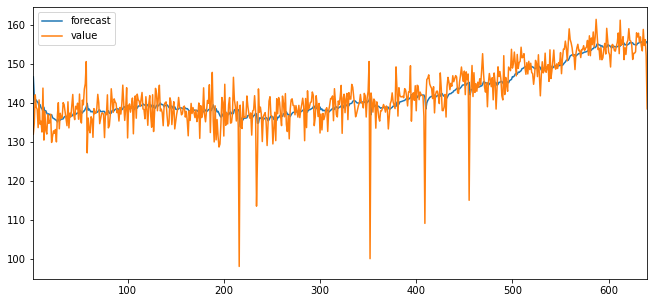

In [56]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()


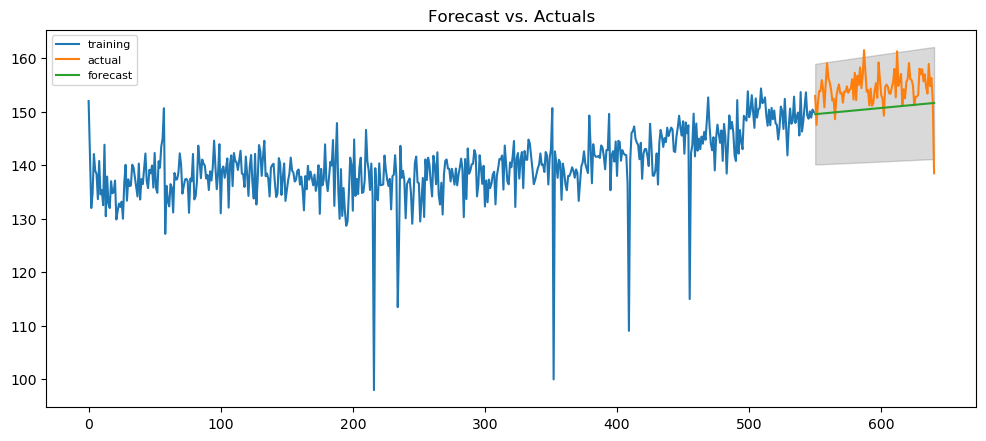

In [57]:
train = df.value[:550]
test = df.value[550:]

# Build Model
# model = ARIMA(train, order=(3,2,1))
model = ARIMA(train, order=(1, 1, 1))
fitted = model.fit(disp=-1)

# Forecast
fc, se, conf = fitted.forecast(91, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('Forecast vs. Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


## Future work

- In order to make a good prediction of how the HS2 will affect the house prices we might take an example from another country which implemented such infrastructure. For example in Italy the high speed train connecting Rome with Milan or Naples.

- It would be nice if we compared the house prices trend with another city where HS2 does not pass or the average house of the UK.

- Connect with Google API and associate GPS location distance from city centre or distance from the train station. Properties with minimum commute from the HS2 station might get a significant price increase.

- Split in circles the areas where the HS2 passes and model by area.

- Group properties by age or type and map them on Birmingham map. We can identify possible refurbishment opportunities and together with HS2 will add value to the property.

- Nice to look the data before 2009, i.e. before the HS2 was announced.

## Notes

- A company named HS2 was set up in January 2009 by the Department for Transport (DfT) for the development of the HS2 project. The company submitted the proposals to the government in the first quarter of 2010 and the preferred route option was announced in October 2010. Good to have data before this date.